# DIVERS Variance and Covariance Decomposition

## 1) Read in absolute abundance tables (generated from preprocess_OTU_relative_abundane_table.ipynb) 


In [71]:
%Directory containing absolute abundance tables
file_dir = ['/Path/To/.../absolute_abundances/'];

%data_X (Samples that represent one of the two technical replicates from each time point)
T_X = readtable([file_dir 'data_X.txt'],'Delimiter','\t');
otu_ids = table2array(T_X(:,1));
tax = table2array(T_X(:,end));
data_X = table2array(T_X(:,2:end-1));
[Mx,Nx] = size(data_X);

%data_Y (Samples that represent the second the two technical replicates from each time point)
T_Y = readtable([file_dir 'data_Y.txt'],'Delimiter','\t');
data_Y = table2array(T_Y(:,2:end-1));
[My,Ny] = size(data_Y);

%data_Z (Samples that represent the second spatial replicate from each time point)
T_Z = readtable([file_dir 'data_Z.txt'],'Delimiter','\t');
data_Z = table2array(T_Z(:,2:end-1));
[Mz,Nz] = size(data_Z);


## 2) Calculate marginal (total) mean abundances and abundance variances of each OTU 

In [72]:
marg_means = [];
marg_vars = [];

% Perform 500 different re-sampling iterations

for i = 1:5e2
    
    data_X_perm = [];
    
    %Randomly draw a sample from data_X, data_Y or data_Z
    for j = 1:Nx
        flip = rand;
        if flip > (2/3)
            data_X_perm(:,j) = data_X(:,j);
        elseif flip > (1/3)
            data_X_perm(:,j) = data_Y(:,j);
        else
            data_X_perm(:,j) = data_Z(:,j);
        end
    end
    
    %Estimate mean and variance from this iteration
    marg_means(:,i) = mean(data_X_perm,2);
    marg_vars(:,i) = var(data_X_perm')';
end

%Average over all re-sampling iterations
means = mean(marg_means,2);
vars_total = mean(marg_vars,2);


### These are the total abundance variances for every OTU

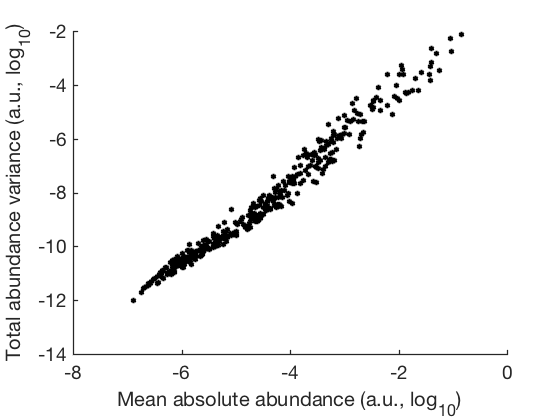

In [73]:
f2 = figure;
p2 = plot(log10(means),log10(vars_total),'ko');
p2.MarkerSize = 3;
p2.MarkerFaceColor = 'k';
xlabel('Mean absolute abundance (a.u., log_{10})')
ylabel('Total abundance variance (a.u., log_{10})')
set(gca,'FontSize',14)
set(gca,'LineWidth',1)
box off

## 3) Variance decomposition of OTU abundances (should take several seconds)


In [74]:
disp(['Performing variance decomposition...'])


covs_XZ = [];
covs_XmZY = [];
vars_XmY = [];

%Perform 500 re-sampling iterations
for i = 1:5e2

    data_X_perm = [];
    data_Y_perm = [];
    
    %Randomly permute X and Y, Z stays the same
    for j = 1:Nx
        flip = rand;
        if flip > .5
            data_X_perm(:,j) = data_X(:,j);
            data_Y_perm(:,j) = data_Y(:,j);
        else
            data_X_perm(:,j) = data_Y(:,j);
            data_Y_perm(:,j) = data_X(:,j);
        end
    end
    
    %Temporal variance
    cov_XZ = [];
    for j = 1:Mx
        covmat_xz = cov(data_X_perm(j,:),data_Z(j,:));
        cov_xz = covmat_xz(1,2);
        cov_XZ(j) = cov_xz;
    end
    covs_XZ(:,i) = cov_XZ';
    
    %Spatial sampling variance
    cov_XmZY = [];
    for j = 1:Mx
        covmat_xmzy = cov(data_X_perm(j,:)-data_Z(j,:),data_Y_perm(j,:));
        cov_xmzy = covmat_xmzy(1,2);
        cov_XmZY(j) = cov_xmzy;
    end
    covs_XmZY(:,i) = cov_XmZY';
    
    %Technical
    var_XmY = .5 * var((data_X_perm - data_Y_perm)')';
    vars_XmY(:,i) = var_XmY;
    
end

%% Average over re-sampling iterations

%Temporal variance
vars_T = mean(covs_XZ,2);
vars_T = max(vars_T,0); 

%Spatial sampling variance
vars_S = mean(covs_XmZY,2);
vars_S = max(vars_S,0); 

%Technical variance
vars_N = mean(vars_XmY,2);

%Fraction of each component to total variance
vf_N = vars_N ./ (vars_N + vars_S + vars_T);
vf_S = vars_S ./ (vars_N + vars_S + vars_T);
vf_T = vars_T ./ (vars_N + vars_S + vars_T);


disp(['Variance decomposition complete!'])



Performing variance decomposition...
Variance decomposition complete!


### We now have the temporal, spatial and technical variance contributions of every OTU!

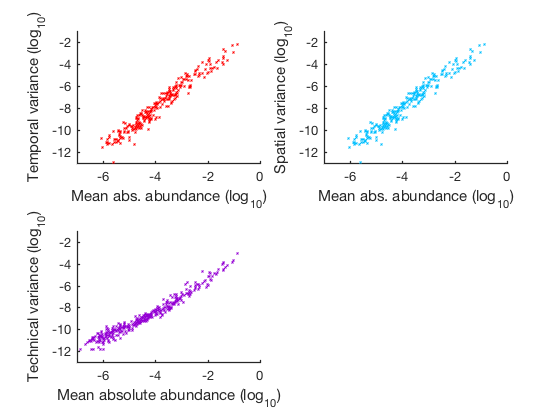

In [75]:
f3 = figure;
addpath('/Path/To/.../matlab_plotting/') %plotting functions
c = @cmu.colors;

subplot(2,2,1)
p3a = plot(log10(means),log10(vars_T),'ro');
p3a.MarkerSize = 1;
p3a.MarkerFaceColor = 'r';
xlabel('Mean abs. abundance (log_{10})')
ylabel('Temporal variance (log_{10})')
set(gca,'FontSize',10)
set(gca,'LineWidth',1)
set(gca,'xlim',[-7,0])
set(gca,'ylim',[-13,-1])
box off

subplot(2,2,2)
p3b = plot(log10(means),log10(vars_T),'ko');
p3b.MarkerSize = 1;
p3b.Color = c('deep sky blue');
p3b.MarkerFaceColor = c('deep sky blue');
xlabel('Mean abs. abundance (log_{10})')
ylabel('Spatial variance (log_{10})')
set(gca,'FontSize',10)
set(gca,'LineWidth',1)
set(gca,'xlim',[-7,0])
set(gca,'ylim',[-13,-1])
box off

subplot(2,2,3)
p3c = plot(log10(means),log10(vars_N),'ko');
p3c.MarkerSize = 1;
p3c.Color = c('dark violet');
p3c.MarkerFaceColor = c('dark violet');
xlabel('Mean absolute abundance (log_{10})')
ylabel('Technical variance (log_{10})')
set(gca,'FontSize',10)
set(gca,'LineWidth',1)
set(gca,'xlim',[-7,0])
set(gca,'ylim',[-13,-1])
box off



## 4) Covariance decomposition of OTU abundances


### a) Calculate total covariances between all OTU pairs

In [76]:
disp(['Calculating total covariances...'])

covs_total = [];

%Perform 500 re-sampling iterations

for i = 1:5e2

    data_X_perm = [];

    %Randomly choose a sample from of data_X, data_Y, data_Z
    for j = 1:Nx
        flip = rand;
        if flip > (2/3)
            data_X_perm(:,j) = data_X(:,j);
        elseif flip > (1/3)
            data_X_perm(:,j) = data_Y(:,j);
        else
            data_X_perm(:,j) = data_Z(:,j);
        end
    end
    
    %Mean center the data 
    data_X_mc = data_X_perm - repmat(mean(data_X_perm,2),1,Nx);
    
    %Calculate covariance matrix
    covmat_X_perm = 1/(Nx-1) * data_X_mc * data_X_mc';
    
    %Store covariance matrix for this iteration
    covs_total(:,:,i) = covmat_X_perm;  
    
end
covmat_total = mean(covs_total,3);
clear covs_total;

disp(['Total covariances calculated!'])


Calculating total covariances...
Total covariances calculated!


### b) Calculate temporal covariances between all OTU pairs (should take several seconds)

In [77]:
disp(['Calculating temporal covariances...'])

crosscovs_T = [];

%Perform 500 re-sampling iterations
for i = 1:5e2

    data_X_perm = [];
    data_Y_perm = [];
    data_Z_perm = data_Z;
    
    %One realization of the data
    for j = 1:Nx
        flip = rand;
        if flip > .5
            data_X_perm(:,j) = data_X(:,j);
            data_Y_perm(:,j) = data_Y(:,j);
        else
            data_X_perm(:,j) = data_Y(:,j);
            data_Y_perm(:,j) = data_X(:,j);
        end
    end
    
    %Mean center matrices;
    data_X_mc = data_X_perm - repmat(mean(data_X_perm,2),1,Nx);
    data_Y_mc = data_Y_perm - repmat(mean(data_Y_perm,2),1,Ny);
    data_Z_mc = data_Z_perm - repmat(mean(data_Z_perm,2),1,Nz);
    
    %Calculate all pairwise covariances for this realization (2
    %permutations)
    covmat_XZ = 1/(Nx-1) * data_X_mc*data_Z_mc'; %(X_i,Z_j)
    covmat_ZX = 1/(Nx-1) * data_Z_mc*data_X_mc'; %(Z_i,X_j)
    covmat = 1/2 * (covmat_XZ + covmat_ZX);
    
    %Store covmat for each realization
    crosscovs_T(:,:,i) = covmat;    
    
end

%Average over all iterations
covmat_T = mean(crosscovs_T,3);
clear crosscovs_T;

disp(['Temporal covariances calculated!'])


Calculating temporal covariances...
Temporal covariances calculated!


### c) Calculate spatial sampling covariances between all OTU pairs (should take several seconds)

In [78]:
disp(['Calculating spatial covariances...'])


crosscovs_S = [];

%Peform 500 re-sampling iterations
for i = 1:5e2

    data_X_perm = [];
    data_Y_perm = [];
    data_Z_perm = data_Z;
    
    %One realization of the data
    for j = 1:Nx
        flip = rand;
        if flip > .5
            data_X_perm(:,j) = data_X(:,j);
            data_Y_perm(:,j) = data_Y(:,j);
        else
            data_X_perm(:,j) = data_Y(:,j);
            data_Y_perm(:,j) = data_X(:,j);
        end
    end
    
    data_XmZ = data_X_perm - data_Z_perm;
    
    %Mean center matrices;
    data_XmZ_mc = data_XmZ - repmat(mean(data_XmZ,2),1,Nx);
    data_Y_mc = data_Y_perm - repmat(mean(data_Y_perm,2),1,Ny);
    
    %Calculate all pairwise covariances for this realization (2
    %permutations)
    covmat_XZY = 1/(Nx-1) * data_XmZ_mc*data_Y_mc';
    covmat_YXZ = 1/(Nx-1) * data_Y_mc*data_XmZ_mc';
    covmat = 1/2 * (covmat_XZY + covmat_YXZ);
    
    %Store covmat for each realization
    crosscovs_S(:,:,i) = covmat;  
    
end

%Average over all iterations
covmat_S = mean(crosscovs_S,3);
clear crosscovs_S;


disp(['Spatial covariances calculated!'])

Calculating spatial covariances...
Spatial covariances calculated!


### d) Calculate technical covariances between all OTU pairs (should take several seconds)

In [79]:
disp(['Calculating technical covariances...'])

crosscovs_N = [];

%Peform 500 re-sampling iterations
for i = 1:5e2

    data_X_perm = [];
    data_Y_perm = [];
    data_Z_perm = data_Z;
    
    %One realization of the data
    for j = 1:Nx
    flip = rand;
        if flip > .5
            data_X_perm(:,j) = data_X(:,j);
            data_Y_perm(:,j) = data_Y(:,j);
        else
            data_X_perm(:,j) = data_Y(:,j);
            data_Y_perm(:,j) = data_X(:,j);
        end
    end
   
    data_XmY = data_X_perm - data_Y_perm;
    
    %Mean center matrices;
    data_XmY_mc = data_XmY - repmat(mean(data_XmY,2),1,Nx);
    
    %Calculate all pairwise covariances for this realization (1
    %permutation)
    covmat = 1/(Nx-1) * data_XmY_mc*data_XmY_mc';
    
    %Store covmat for each realization
    crosscovs_N(:,:,i) = .5 * covmat;   
   
end

%Average over all iterations
covmat_N = mean(crosscovs_N,3);  
clear crosscovs_N;

disp(['Technical covariances calculated!'])


Calculating technical covariances...
Technical covariances calculated!


## 5) Rescale covariances to obtain correlations

In [80]:
L = length(vars_total);

%Calculate product of marginal standard deviations for each pair of OTUs
sigxsigy = [];
for i = 1:L
   for j = 1:i
       if vars_total(i) > 0 && vars_total(j) > 0
            sigxsigy(i,j) = sqrt(vars_total(i))*sqrt(vars_total(j));
            sigxsigy(j,i) = sqrt(vars_total(i))*sqrt(vars_total(j));
       else
            sigxsigy(i,j) = 0;
            sigxsigy(j,i) = 0;
       end
   end
end

cormat_total = covmat_total ./ sigxsigy;
cormat_T = covmat_T ./ sigxsigy;
cormat_S = covmat_S ./ sigxsigy;
cormat_N = covmat_N ./ sigxsigy;


    
clear covs_XZ covs_XmZY vars_XmY sigxsigy data_X_perm data_Y_perm data_Z_perm data_X_mc data_Y_mc data_Z_mc data_XmY_mc data_XmZ_mc data_XmY data_XmZ


### We now have the temporal, spatial, and technical correlation contributions for all pairs of OTUs!

> In colorGradient (line 32)
> In colorGradient (line 32)


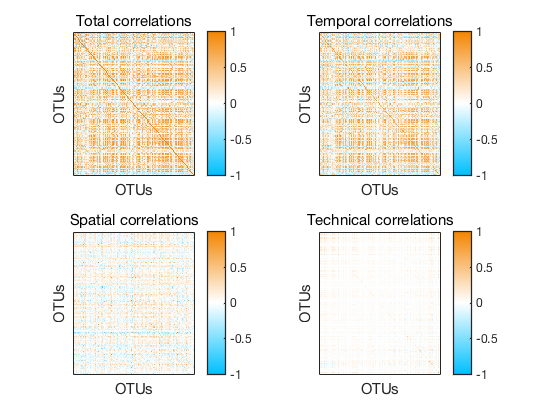

In [81]:
f5 = figure;

cmap1 = colorGradient(c('deep sky blue'),c('white'),500);
cmap2 = colorGradient(c('white'),c('tangerine'),500);
cmap = [cmap1;cmap2];
colormap(cmap);


%Plot the correlation heatmaps

high_inds = find(log10(means) > -4); %Show only abundant OTUs

%Total correlations
subplot(2,2,1)
p5a = imagesc(cormat_total(high_inds,high_inds));
set(gca,'XTick',[])
set(gca,'YTick',[])
xlabel('OTUs')
ylabel('OTUs')
title('Total correlations','FontWeight','Normal')
c5a = colorbar;
c5a.LineWidth = 1;
caxis([-1,1]);
c5a.Limits = [-1 1];

%Temporal correlations
subplot(2,2,2)
p5b = imagesc(cormat_T(high_inds,high_inds));
set(gca,'XTick',[])
set(gca,'YTick',[])
xlabel('OTUs')
ylabel('OTUs')
title('Temporal correlations','FontWeight','Normal')
c5b = colorbar;
c5b.LineWidth = 1;
caxis([-1,1]);
c5b.Limits = [-1 1];

%Spatial correlations
subplot(2,2,3)
p5c = imagesc(cormat_S(high_inds,high_inds));
set(gca,'XTick',[])
set(gca,'YTick',[])
xlabel('OTUs')
ylabel('OTUs')
title('Spatial correlations','FontWeight','Normal')
c5c = colorbar;
c5c.LineWidth = 1;
caxis([-1,1]);
c5c.Limits = [-1 1];

%Technical correlations
subplot(2,2,4)
p5d = imagesc(cormat_N(high_inds,high_inds));
set(gca,'XTick',[])
set(gca,'YTick',[])
xlabel('OTUs')
ylabel('OTUs')
title('Technical correlations','FontWeight','Normal')
c5d = colorbar;
c5d.LineWidth = 1;
caxis([-1,1]);
c5d.Limits = [-1 1];


## 6) Saving

In [82]:
%Save DIVERS variance and covariance decomposition results into a MAT file
save_dir = ['/Path/To/.../matData/'];
save([save_dir 'DIVERS.mat']);
